In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import pickle

In [311]:
data=pd.read_csv("trimmed_data.csv",index_col=0)
#data=pd.read_csv("new_data.csv",index_col=0)

In [312]:
corr = data.corr()
corr.style.background_gradient(cmap='binary')

In [217]:
data['X']=0
def fun(srs):
    '''
    if srs.X3>0:
        srs.X3=1 
    if srs.X3<0:
        srs.X3=-1
    if srs.X4>0:
        srs.X4=1 
    if srs.X4<0:
        srs.X4=-1
    if srs.X6>0:
        srs.X6=1 
    if srs.X6<0:
        srs.X6=-1
    if srs.X7>0:
        srs.X7=1 
    if srs.X7<0:
        srs.X7=-1
    if srs.sec_id>0.5:
        srs.sec_id=1 
    else:
        srs.sec_id=0
    '''
    srs.X=srs.X3+srs.X4+srs.X6+srs.X7
    return srs

data.apply(fun,axis=1)

print('*')


*


In [313]:
data.head()

Date    sec_id   fut_ret       vol        X1        X3   X4   X6        X7
0   0.0  0.000000  0.037521  0.269877  1.876823  0.000000  0.0  0.0  0.000000
1   0.0  0.000502  0.005565  0.879423 -0.670540  0.000000  0.0  0.0  0.000000
2   0.0  0.001005 -0.008732  0.331473  0.940755  0.923608  0.0  0.0 -0.379818
3   0.0  0.001507  0.000695 -0.598987 -0.114191  0.000000  0.0  0.0  0.000000
4   0.0  0.002009 -0.002755 -0.057603 -0.101973  0.000000  0.0  0.0  0.000000

In [314]:
X_all=np.array(data[['sec_id','vol','X1','X3','X4','X6','X7']])
#X_all=np.array(data[['sec_id','X1','X3','X4','X6','X7']])
#X_all=np.array(data[['sec_id','vol','X1','X']])
y_all=np.array(data['fut_ret'])

# test:cv:train=2:2:6
X_all_train, X_all_test, y_all_train, y_all_test = train_test_split(X_all, y_all, test_size=0.2)
X_all_train, X_all_cv, y_all_train, y_all_cv = train_test_split(X_all_train, y_all_train, test_size=0.25)

# Winsorize data
#y_all_train=np.clip(y_all_train,a_min=-0.051681,a_max=0.051951)

train_all=(X_all_train,y_all_train)
cv_all=(X_all_cv,y_all_cv)

In [315]:
def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.01)

In [316]:
def NN( data_set, test_set, nodes=[16], epoch=1000, learning_rate=1e-3, is_drop=False, l2_reg=0, is_leaky=False,
        is_batch=False):
    x = torch.tensor(data_set[0], dtype=torch.float32)
    y = torch.tensor(data_set[1][:, np.newaxis], dtype=torch.float32)
    
    # model initialize
    out_size = 1
    F = x.shape[1]
    layer_num = len(nodes)

    # add layers
    model = torch.nn.Sequential()
    model.add_module("linear 0", torch.nn.Linear(F, nodes[0]))
    if is_batch:
        model.add_module("batch 0",torch.nn.BatchNorm1d(nodes[0]))   
    if is_drop:
        model.add_module("drop 0", torch.nn.Dropout(0.5))
    model.add_module("relu 0", torch.nn.ReLU() if not is_leaky else torch.nn.PReLU())
    

    for i in range(layer_num-1):
        model.add_module("linear "+str(i+1),torch.nn.Linear(nodes[i], nodes[i+1]))
        if is_batch:
            model.add_module("batch "+str(i+1),torch.nn.BatchNorm1d(nodes[i+1]))
        if is_drop:
            model.add_module("drop "+str(i+1), torch.nn.Dropout(0.5))
        model.add_module("relu "+str(i+1), torch.nn.ReLU() if not is_leaky else torch.nn.PReLU())
        
    
    # HE initial
    model.apply(init_weights)
    
    #output layer
    model.add_module("linear "+str(layer_num),
                     torch.nn.Linear(nodes[-1], out_size))

    # loss
    #loss_fn = torch.nn.MSELoss()    
    loss_fn=torch.nn.L1Loss()
    
    # optimizer
    optimizer = torch.optim.Adam(
        model.parameters(), lr=learning_rate, weight_decay=l2_reg)

    # training
    loss_history = []
    loss_old=float('inf')
    loss_new=0
    count=0

    for t in range(epoch):
        y_pred = model(x)

        loss_new = loss_fn(y_pred, y)
        
        if abs(loss_old-loss_new)<1e-9:
            count=count+1
        else:
            count=0
            
        if count>30:
            print("converge epoch: ",t)
            break
            
        loss_old = loss_new
        
        #if loss<0.000296:
        #    print("converge epoch: ",t)
        #    break

        if t % 100 == 99:
            print("epoch ", t+1, ", loss is ", loss_new.item())
        #loss_history.append(loss.item())

        optimizer.zero_grad()

        loss_new.backward()

        optimizer.step()

    # plot loss evolution
    #plt.figure(figsize=(14, 7))
    #plt.plot(range(len(loss_history)), loss_history)
    #plt.xlabel("epoch")
    #plt.ylabel("loss")
    #plt.show()

    # testing
    x_test = torch.tensor(test_set[0], dtype=torch.float32)
    y_test = torch.tensor(test_set[1][:, np.newaxis], dtype=torch.float32)
    
    y_in_pred = model(x)
    y_out_pred = model(x_test)
    
    err_in = loss_fn(y_in_pred, y).item()
    err_out = loss_fn(y_out_pred, y_test).item()
    
       
    y=data_set[1]
    y_test=test_set[1]
    y_in_pred=torch.Tensor.numpy(y_in_pred.data)
    y_in_pred.reshape(y_in_pred.shape[0])
    y_out_pred=torch.Tensor.numpy(y_out_pred.data)
    y_out_pred.reshape(y_out_pred.shape[0])
    
    r2_in = r2_score(y, y_in_pred)
    r2_out = r2_score(y_test, y_out_pred)

    #print("\nin-sample error: ", err_in)
    #print("out-of-sample error: ", err_out)
    #print("in-sample r2: ", r2_in)
    #print("out-of-sample r2: ", r2_out)

    return (model,r2_out,err_in)

In [317]:
# for test
def test_r2(model,X = X_all_test,y = y_all_test):   
    y_pred=model(torch.tensor(Ｘ, dtype=torch.float32))
    y_pred=torch.Tensor.numpy(y_pred.data)
    y_pred.reshape(y_pred.shape[0])
    plt.figure(figsize=(16,7))
    plt.hist(y_pred,range=(-0.002,0.002),bins=30)
    r2 = r2_score(y, y_pred)
    return r2


def MDA(model,X = X_all_test,y = y_all_test):
    feature_num=X.shape[1]
    r2_origin = test_r2(model,X,y)
    print("origin: ",r2_origin)
    for i in range(feature_num):
        r2_new_lst=[]
        for j in range(10):
            X_new=X.copy()
            np.random.shuffle(X_new[:,i])
            r2_new=test_r2(model,X_new,y)
            r2_new_lst.append(r2_new)
        is_valid=" *"
        if np.mean(r2_new_lst)>r2_origin:
            is_valid=" "
        if abs(np.mean(r2_new_lst)-r2_origin)/abs(r2_origin)<0.01:
            is_valid=" "
        print("suffle feature ",i,": ",np.mean(r2_new_lst),is_valid)

In [68]:
#MDA(grid_history[-1][1])

[0.009766577742993832, [128, 16, 16, 16, 16], 10000, 0.01, True, 0.01, True, False]
-3.273725602381816e-05
-0.00015823044288620913 , in sample:  -7.560558910357784e-05 



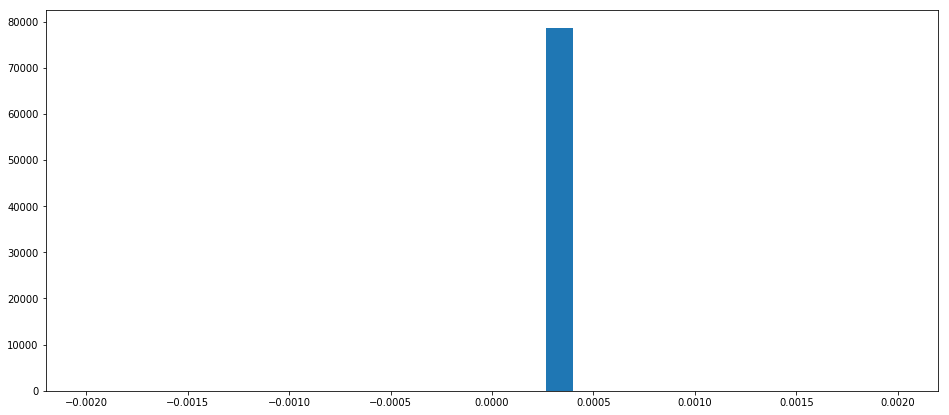

In [319]:
#for i in range(1,len(grid_history)+1):
i=1 
print(grid_history[-i][2:])
print(grid_history[-i][0])
print(test_r2(grid_history[-i][1]),", in sample: ",test_r2(grid_history[-i][1],X_all_train,y_all_train),'\n')


In [123]:
for i in range(1,len(grid_history2)+1):
    print(grid_history2[-i][2:])
    print(grid_history2[-i][0])
    print(test_r2(grid_history2[-i][1]),", in sample: ",test_r2(grid_history2[-i][1],X_all_train,y_all_train),'\n')

for i in range(1,len(grid_history1)+1):
    print(grid_history1[-i][2:])
    print(grid_history1[-i][0])
    print(test_r2(grid_history1[-i][1]),", in sample: ",test_r2(grid_history1[-i][1],X_all_train,y_all_train),'\n')

[0.00030693586450070143, [64, 64], 10000, 0.001, True, 0.01, True, True]
-3.777797376791625e-05
-3.45969867421303e-06 , in sample:  1.3267498535696198e-05 

[0.0003069373487960547, [64, 64], 10000, 0.001, True, 0.1, False]
-4.880653519845346e-05
-9.10207280102604e-06 , in sample:  1.4115906080247598e-05 

[0.0003069371450692415, [64, 64], 10000, 0.001, True, 0.1, True]
-4.105563740153251e-05
-2.7479496396143333e-06 , in sample:  1.010154744240932e-05 

[0.00030693921144120395, [64, 64], 10000, 0.001, True, 0.01, False]
-3.91739795324586e-05
-3.850801181481955e-06 , in sample:  4.76217728295758e-06 

[0.0003069363592658192, [64, 64], 10000, 0.001, True, 0.01, True]
-3.09392828132804e-05
2.188198898633864e-06 , in sample:  1.2539210090700692e-05 

[0.00030694264569319785, [64, 64], 10000, 0.001, True, 0.001, False]
-6.496190237958999e-05
-2.3159146008477904e-05 , in sample:  -4.726967861801157e-06 

[0.0003069372905883938, [64, 64], 10000, 0.001, True, 0.001, True]
-3.73809510296752e-05


In [113]:
#for i in np.linspace(1e-3,1e-2,4):
model,r2,mse=NN(train_all,cv_all,[128], 10000, 1e-3, False, 1e-2, True,False)
grid_history.append([r2,model,mse,[128], 10000, 1e-3, False, 1e-2, True])
print(t,": ",r2,"  ",mse,"  ",[128], False, 1e-2, True)

epoch  1000 , loss is  0.009981795214116573
epoch  2000 , loss is  0.00981492456048727
epoch  3000 , loss is  0.009771928191184998
epoch  4000 , loss is  0.009785587899386883
epoch  5000 , loss is  0.009777273051440716
epoch  6000 , loss is  0.00976316723972559
epoch  7000 , loss is  0.009769751690328121
epoch  8000 , loss is  0.009774324484169483
epoch  9000 , loss is  0.009762054309248924
epoch  10000 , loss is  0.009772260673344135
7 :  -0.00013317449458494224    0.009767658077180386    [128] False 0.01 True


### DAY 1 Experiment

In [177]:
grid_history=[]

In [318]:
nodes_list=[
    [128,16,16,16,16]
]          

t=1 
for nodes in nodes_list:
    for epoch in [10000]:
        for lr in [1e-2]:
            for isdrop in [True]:
                for l2reg in [1e-2]:
                    for isleaky in [True]:
                        for isbatch in [False]:
                            model,r2,mse=NN(train_all,cv_all,nodes, epoch, lr, isdrop, l2reg, isleaky, isbatch)
                            grid_history.append([r2,model,mse,nodes, epoch, lr, isdrop, l2reg, isleaky, isbatch])
                            print(t,": ",r2,"  ",mse,"  ",nodes, isdrop, l2reg, isleaky, isbatch)
                            t=t+1





epoch  100 , loss is  0.009800838306546211
epoch  200 , loss is  0.009743771515786648
epoch  300 , loss is  0.009791131131350994
epoch  400 , loss is  0.009794083423912525
epoch  500 , loss is  0.009795330464839935
epoch  600 , loss is  0.009794903919100761
epoch  700 , loss is  0.009797940030694008
epoch  800 , loss is  0.009800132364034653
epoch  900 , loss is  0.009797788225114346
epoch  1000 , loss is  0.009797954000532627
epoch  1100 , loss is  0.00979797076433897
epoch  1200 , loss is  0.009798044338822365
epoch  1300 , loss is  0.009802669286727905
epoch  1400 , loss is  0.009802654385566711
epoch  1500 , loss is  0.009802711196243763
epoch  1600 , loss is  0.009802712127566338
epoch  1700 , loss is  0.009802759625017643
epoch  1800 , loss is  0.00980278942734003
epoch  1900 , loss is  0.00980279128998518
epoch  2000 , loss is  0.009802772663533688
epoch  2100 , loss is  0.009802852757275105
epoch  2200 , loss is  0.00980284996330738
epoch  2300 , loss is  0.00980285182595253
ep

In [116]:
# write history
##with open('grid_history_1layer.data', 'wb') as filehandle:  
    pickle.dump(grid_history, filehandle)

In [121]:
# load history
with open('grid_history_2layer.data', 'rb') as filehandle:  
    grid_history2 = pickle.load(filehandle)
    
with open('grid_history_1layer.data', 'rb') as filehandle:  
    grid_history1 = pickle.load(filehandle)

In [ ]:
# save whole model
torch.save(model, PATH)

In [ ]:
# load whole model
model = torch.load(PATH)
model.eval()

In [ ]:
ind=['r2','mse','nodes', 'isdrop', 'l2reg', 'isleaky']
s=[0,2,3,6,7,8]
record_df={}
for i in range(len(s)):
    tmp=[]
    for lst in grid_history:
        tmp.append(lst[i])
    record_df[ind[i]]=tmp

record_df=pd.DataFrame(record_df)


In [ ]:
possible_node=[16,32]
nodes_list=[]
for k in possible_node:
    nodes_list.append([k])
for k1 in possible_node:
    for k2 in possible_node:
        nodes_list.append([k1,k2])
for k1 in possible_node:
    for k2 in possible_node:
        for k3 in possible_node:
            nodes_list.append([k1,k2,k3])
   

In [14]:
torch.__version__

'1.1.0'